## APPLIED COMPUTER VISION HOMEWORK 3

### Imports

In [14]:
!pip install pycocotools
!pip install opencv-python
!pip install matplotlib
!pip install torch torchvision
# Install required packages
!pip install   pytorch-lightning albumentations

## IMPORTS

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Dataset

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


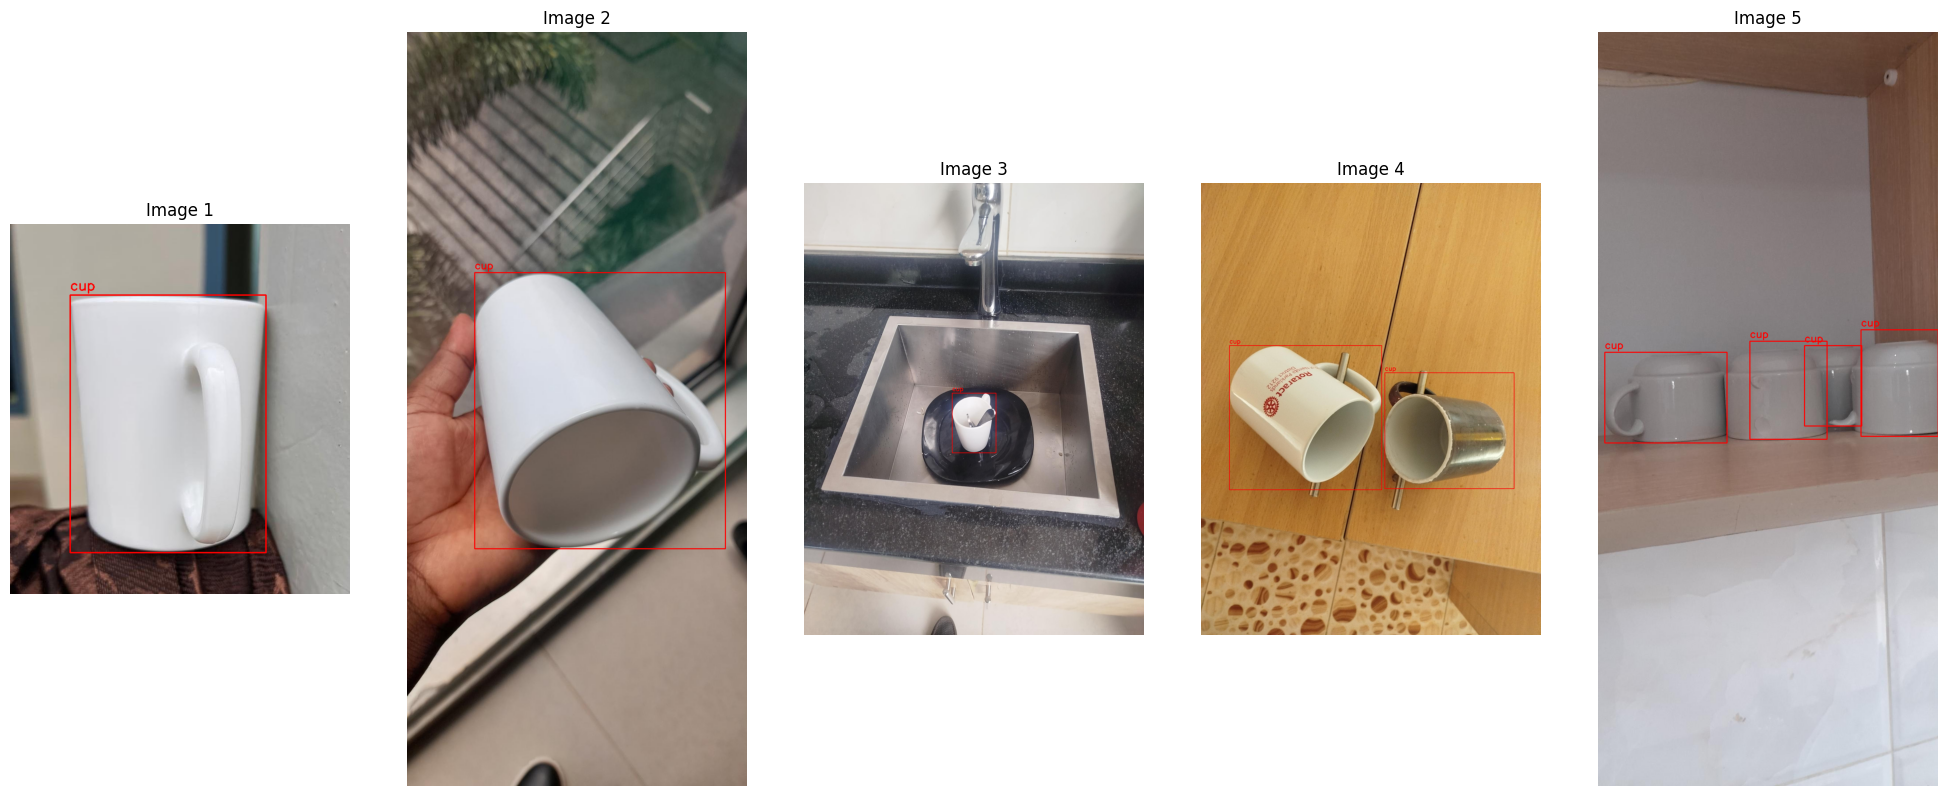

In [16]:
# Path to your dataset
# Set your dataset paths
train_annotations_path = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/train/_annotations.coco.json'
train_images_dir = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/train'

val_annotations_path = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/valid/_annotations.coco.json'
val_images_dir = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/valid'

test_annotations_path = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/test/_annotations.coco.json'
test_images_dir = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/test'

# For Exploratory Data Analysis
data_dir = '/kaggle/input/annotated-cups/annotated cups.v2i.coco - split/'
annotations_path = os.path.join(data_dir, 'train/_annotations.coco.json')

# Load COCO annotations
coco = COCO(annotations_path)

# Get image IDs and category IDs
image_ids = coco.getImgIds()
category_ids = coco.getCatIds()

# Create a grid of subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 20))  # 1 row, 5 columns for 5 images
fig.tight_layout()

# Display the first 5 images with annotations
for i, img_id in enumerate(image_ids[:5]):  # Check first 5 images
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, 'train/', img_info['file_name'])  # Adjust path as needed
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Load annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Draw bounding boxes on the image
    for ann in anns:
        x, y, w, h = ann['bbox']
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
        category_name = coco.loadCats(ann['category_id'])[0]['name']
        cv2.putText(image, category_name, (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Image {i + 1}")

# Show the grid
plt.show()

In [17]:

# COCO Dataset class
class COCOCupDataset(Dataset):
    def __init__(self, annotation_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load COCO format annotations
        with open(annotation_path, 'r') as f:
            self.coco_data = json.load(f)
            
        # Create image_id to annotations mapping
        self.image_id_to_annotations = {}
        for ann in self.coco_data['annotations']:
            image_id = ann['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(ann)
            
        # Filter images with annotations
        self.images = [img for img in self.coco_data['images'] 
                      if img['id'] in self.image_id_to_annotations]
        
        # Create category ID to index mapping (0 is background in PyTorch)
        self.cat_ids = [cat['id'] for cat in self.coco_data['categories']]
        self.cat_id_to_idx = {cat_id: i + 1 for i, cat_id in enumerate(self.cat_ids)}  # +1 for background
        
        print(f"Loaded {len(self.images)} images with annotations")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get image dimensions for normalization
        height, width = image.shape[:2]
        
        # Get annotations
        image_id = img_info['id']
        annotations = self.image_id_to_annotations[image_id]
        
        boxes = []
        labels = []
        
        for ann in annotations:
            # COCO format is [x, y, width, height]
            x, y, w, h = ann['bbox']
            
            # Convert to [x_min, y_min, x_max, y_max] format
            x_min = max(0, x)
            y_min = max(0, y)
            x_max = min(width, x + w)
            y_max = min(height, y + h)
            
            # Skip invalid boxes
            if x_min >= x_max or y_min >= y_max:
                continue
                
            boxes.append([x_min, y_min, x_max, y_max])
            cat_id = ann['category_id']
            labels.append(self.cat_id_to_idx[cat_id])
        
        # Skip images with no valid boxes
        if len(boxes) == 0:
            # Return a dummy sample that will be filtered out
            dummy_box = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
            dummy_label = torch.tensor([1], dtype=torch.int64)
            return torch.zeros((3, 100, 100)), {"boxes": dummy_box, "labels": dummy_label, "image_id": torch.tensor([image_id])}
        
        # Apply transforms
        if self.transform:
            # Convert box coordinates to the format expected by albumentations
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
        
        # Convert to tensor format (if not already converted by transform)
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Create target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([image_id])
        
        return image, target

# Create transforms for data augmentation
def get_transforms(train):
    if train:
        return A.Compose([
            A.Resize(height=512, width=512),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.3))
    else:
        return A.Compose([
            A.Resize(height=512, width=512),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.3))

# Custom collate function to handle empty batches
def collate_fn(batch):
    # Filter out samples with no valid boxes
    batch = [(img, target) for img, target in batch if len(target['boxes']) > 0]
    
    # If after filtering, batch is empty, create a dummy batch
    if len(batch) == 0:
        return None
    
    return tuple(zip(*batch))



## Model Architecture - Faster R-CNN

In [18]:
# Create model
def get_faster_rcnn_model(num_classes):
    # Load pretrained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


## Training loop

In [19]:
# Training function
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    processed_batches = 0
    
    for batch in data_loader:
        # Skip empty batches
        if batch is None:
            continue
            
        images, targets = batch
        processed_batches += 1
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    # Avoid division by zero if all batches were empty
    if processed_batches == 0:
        return 0
        
    return total_loss / processed_batches


## Evaluation Loop

In [20]:
# Evaluation function - FIXED VERSION
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    processed_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # Skip empty batches
            if batch is None:
                continue
                
            images, targets = batch
            processed_batches += 1
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Temporarily switch to training mode to get losses
            model.train()
            loss_dict = model(images, targets)
            model.eval()  # Switch back to eval mode
            
            # Sum the losses
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
    
    # Avoid division by zero if all batches were empty
    if processed_batches == 0:
        return 0
        
    return total_loss / processed_batches

# Visualization function
def visualize_predictions(model, data_loader, device, threshold=0.5, num_images=5):
    model.eval()
    
    # Get a batch of data
    for batch in data_loader:
        if batch is None:
            continue
        images, targets = batch
        break
    
    # Move to device
    images = list(image.to(device) for image in images)
    
    # Perform inference
    with torch.no_grad():
        predictions = model(images)
    
    # Visualize results
    for i in range(min(num_images, len(images))):
        # Get image
        image = images[i].cpu().permute(1, 2, 0).numpy()
        # Denormalize
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        image = image.astype(np.uint8)
        
        # Get ground truth boxes
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        gt_labels = targets[i]['labels'].cpu().numpy()
        
        # Get predictions
        pred_boxes = predictions[i]['boxes'].cpu().numpy()
        pred_scores = predictions[i]['scores'].cpu().numpy()
        pred_labels = predictions[i]['labels'].cpu().numpy()
        
        # Filter by threshold
        keep_idx = pred_scores >= threshold
        pred_boxes = pred_boxes[keep_idx]
        pred_scores = pred_scores[keep_idx]
        pred_labels = pred_labels[keep_idx]
        
        # Create copies for drawing
        image_gt = image.copy()
        image_pred = image.copy()
        
        # Draw ground truth
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image_gt, f"Class {label}", (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Draw predictions
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image_pred, f"Class {label}: {score:.2f}", (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Display
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(image_gt)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(image_pred)
        ax2.set_title('Predictions')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

# Performance evaluation
def evaluate_performance(model, data_loader, device, threshold=0.5):
    model.eval()
    
    # Metrics
    total_tp = 0
    total_fp = 0
    total_fn = 0
    inference_times = []
    
    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue
                
            images, targets = batch
            
            # Measure inference time
            start_time = time.time()
            predictions = model([img.to(device) for img in images])
            end_time = time.time()
            inference_times.append((end_time - start_time) / len(images))
            
            # Process predictions
            for i, (prediction, target) in enumerate(zip(predictions, targets)):
                # Get ground truth boxes
                gt_boxes = target['boxes'].cpu().numpy()
                
                # Get predicted boxes
                pred_boxes = prediction['boxes'].cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                
                # Filter by threshold
                keep_idx = pred_scores >= threshold
                pred_boxes = pred_boxes[keep_idx]
                
                # Create copy of gt_boxes to track matches
                gt_matched = [False] * len(gt_boxes)
                
                # Count true positives and false positives
                for pred_box in pred_boxes:
                    best_iou = 0
                    best_gt_idx = -1
                    
                    for j, gt_box in enumerate(gt_boxes):
                        if gt_matched[j]:
                            continue
                            
                        # Calculate IoU
                        x1 = max(pred_box[0], gt_box[0])
                        y1 = max(pred_box[1], gt_box[1])
                        x2 = min(pred_box[2], gt_box[2])
                        y2 = min(pred_box[3], gt_box[3])
                        
                        if x1 < x2 and y1 < y2:
                            intersection = (x2 - x1) * (y2 - y1)
                            area1 = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
                            area2 = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
                            iou = intersection / (area1 + area2 - intersection)
                            
                            if iou > best_iou:
                                best_iou = iou
                                best_gt_idx = j
                    
                    # If IoU > threshold, it's a true positive
                    if best_iou >= 0.5:
                        total_tp += 1
                        gt_matched[best_gt_idx] = True
                    else:
                        total_fp += 1
                
                # Count false negatives (unmatched ground truths)
                total_fn += sum(1 for matched in gt_matched if not matched)
    
    # Calculate metrics
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate average inference time and FPS
    avg_inference_time = sum(inference_times) / len(inference_times) if inference_times else 0
    fps = 1.0 / avg_inference_time if avg_inference_time > 0 else 0
    
    results = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'inference_time_ms': avg_inference_time * 1000,
        'fps': fps
    }
    
    return results

## Execution

Loaded 267 images with annotations
Loaded 20 images with annotations
Loaded 10 images with annotations
Categories:
ID: 0, Name: cups-of-mercy
ID: 1, Name: cup
Total classes: 3
Epoch 1/10
Train Loss: 0.3102
Validation Loss: 0.2783
----------------------------------------
Epoch 2/10
Train Loss: 0.1334
Validation Loss: 0.3030
----------------------------------------
Epoch 3/10
Train Loss: 0.0920
Validation Loss: 0.2758
----------------------------------------
Epoch 4/10
Train Loss: 0.0690
Validation Loss: 0.2721
----------------------------------------
Epoch 5/10
Train Loss: 0.0632
Validation Loss: 0.2828
----------------------------------------
Epoch 6/10
Train Loss: 0.0601
Validation Loss: 0.2805
----------------------------------------
Epoch 7/10
Train Loss: 0.0600
Validation Loss: 0.2814
----------------------------------------
Epoch 8/10
Train Loss: 0.0564
Validation Loss: 0.2826
----------------------------------------
Epoch 9/10
Train Loss: 0.0584
Validation Loss: 0.2823
----------

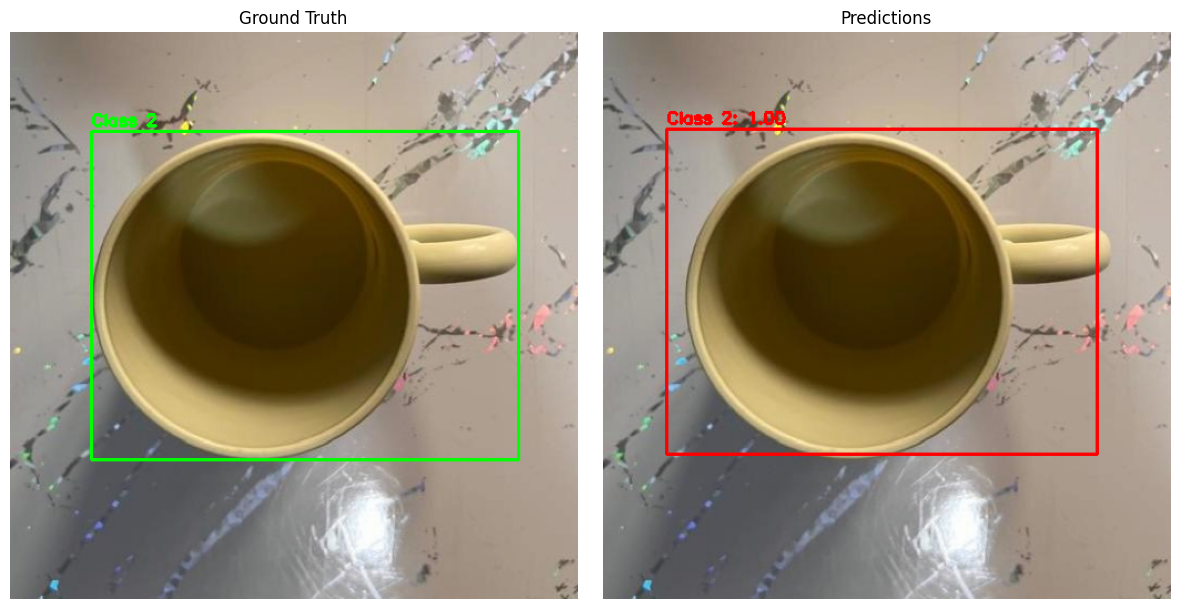

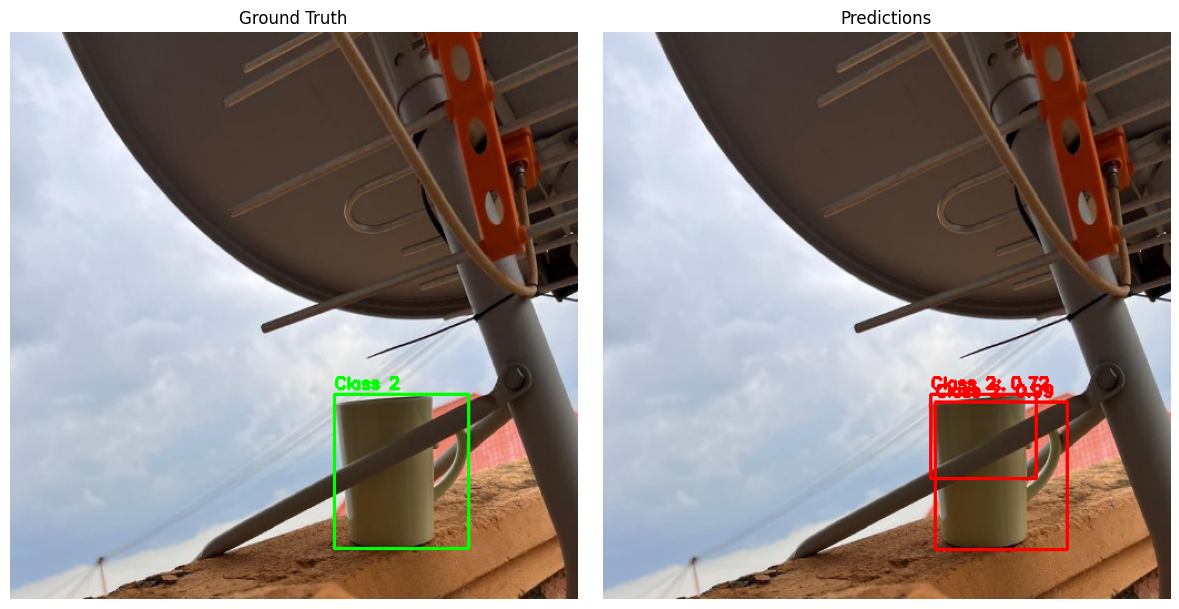

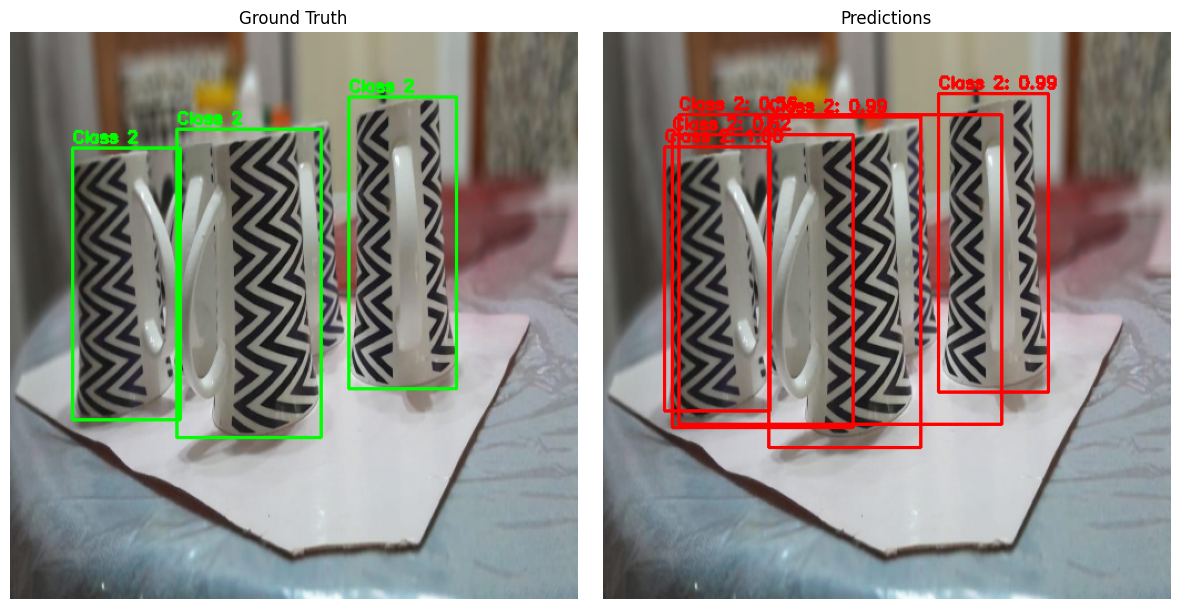

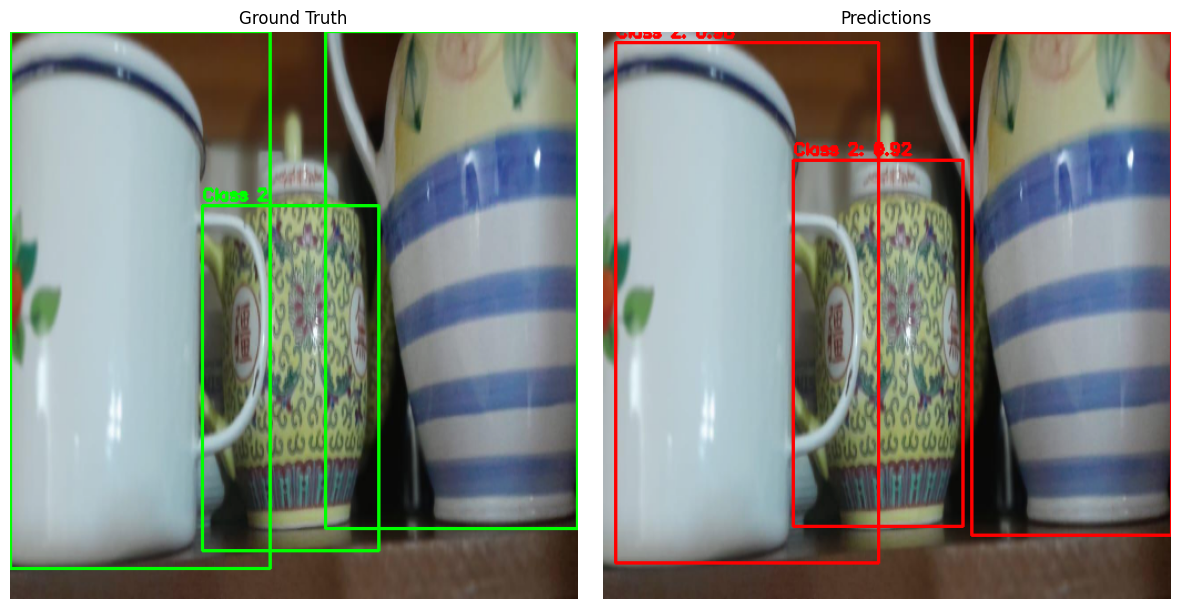

In [21]:
# Main execution function
def main():
    # Create datasets
    train_dataset = COCOCupDataset(train_annotations_path, train_images_dir, transform=get_transforms(train=True))
    val_dataset = COCOCupDataset(val_annotations_path, val_images_dir, transform=get_transforms(train=False))
    test_dataset = COCOCupDataset(test_annotations_path, test_images_dir, transform=get_transforms(train=False))

    # Check categories
    print("Categories:")
    for cat in train_dataset.coco_data['categories']:
        print(f"ID: {cat['id']}, Name: {cat['name']}")

    # Total number of classes (including background)
    num_classes = len(train_dataset.coco_data['categories']) + 1
    print(f"Total classes: {num_classes}")

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    # Initialize model
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_faster_rcnn_model(num_classes)
    model.to(device)

    # Set optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss = train_one_epoch(model, optimizer, train_loader, device)
        print(f"Train Loss: {train_loss:.4f}")
        
        # Evaluate
        val_loss = evaluate(model, val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Update learning rate
        lr_scheduler.step()
        
        print("-" * 40)

    # Save model
    torch.save(model.state_dict(), 'faster_rcnn_cups.pth')

    # Evaluate model performance
    print("Evaluating model performance...")
    results = evaluate_performance(model, test_loader, device)
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"Inference Time: {results['inference_time_ms']:.2f} ms")
    print(f"FPS: {results['fps']:.2f}")

    # Visualize predictions
    print("Visualizing predictions...")
    visualize_predictions(model, test_loader, device)
    
    return model, results

if __name__ == "__main__":
    model, results = main()